In [1]:
!git clone https://github.com/kakaobrain/minDALL-E

fatal: destination path 'minDALL-E' already exists and is not an empty directory.


In [2]:
%cd /content/minDALL-E
!pwd

/content/minDALL-E
/content/minDALL-E


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-424m9swf
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-424m9swf
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Using cached torchvision-0.13.0-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)
  Using cached torchvision-0.12.0-cp37-cp37m-manylinux1_x86_64.whl (21.0 MB)
  Using cached torchvision-0.11.3-cp37-cp37m-manylinux1_x86_64.whl (23.2 MB)
  Using cached torchvision-0.11.2-cp37-cp37m-manylinux1_x86_64.whl (23.3 MB)
  Using cached torchvision-0.11.1-cp37-cp37m-manylinux1_x86_64.whl (23.3 MB)
  Using cached torchvision-0.10.1-cp37-cp37m-manylinux1_x86_64.whl (22.1 MB)
  Using cached torchvision-0.10.0-cp37-cp37m-manylinux1_x86_64.whl (22.1 MB)
  Using cached torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (17.4 MB)
     |████████████████████████████████| 12.8 MB 44.3 MB/s 

In [4]:
!pip install torchtext==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 26.4 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [5]:
import os
import sys
import argparse
import clip
import numpy as np
from PIL import Image

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from dalle.models import Dalle
from dalle.utils.utils import set_seed, clip_score

In [ ]:
!pip install ipywidgets
from ipywidgets import interact

In [6]:

n = num_candidates = 16

prompt = 'A painting of a tree on the ocean'
softmax_temperature = 1.0
top_k = 192
top_p = None #help='0.0 <= top-p <= 1.0'
seed = 0


In [7]:
# Setup
assert top_k <= 256, "It is recommended that top_k is set lower than 256."

set_seed(seed)
device = 'cuda:0'
model = Dalle.from_pretrained('minDALL-E/1.3B')  # This will automatically download the pretrained model.
model.to(device=device)

# Sampling
images = model.sampling(prompt='A painting of a tree on the ocean',
                        top_k=top_k,
                        top_p=top_p,
                        softmax_temperature=softmax_temperature,
                        num_candidates=num_candidates,
                        device=device).cpu().numpy()
images = np.transpose(images, (0, 2, 3, 1))

/root/.cache/minDALL-E/1.3B/tokenizer successfully restored..
/root/.cache/minDALL-E/1.3B/stage1_last.ckpt successfully restored..
/root/.cache/minDALL-E/1.3B/stage2_last.ckpt succesfully restored..


100%|██████████| 256/256 [00:23<00:00, 10.94it/s]


In [8]:
# CLIP Re-ranking
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
model_clip.to(device=device)
rank = clip_score(prompt=prompt,
                  images=images,
                  model_clip=model_clip,
                  preprocess_clip=preprocess_clip,
                  device=device)

# Save images
images = images[rank]
print(rank, images.shape)
if not os.path.exists('./figures'):
    os.makedirs('./figures')
for i in range(min(16, num_candidates)):
    im = Image.fromarray((images[i]*255).astype(np.uint8))
    im.save(f'./figures/{prompt}_{i}.png')

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 112MiB/s]


[13  6  1 14  5  2 15  7  9  3  4  8 11 12  0 10] (16, 256, 256, 3)


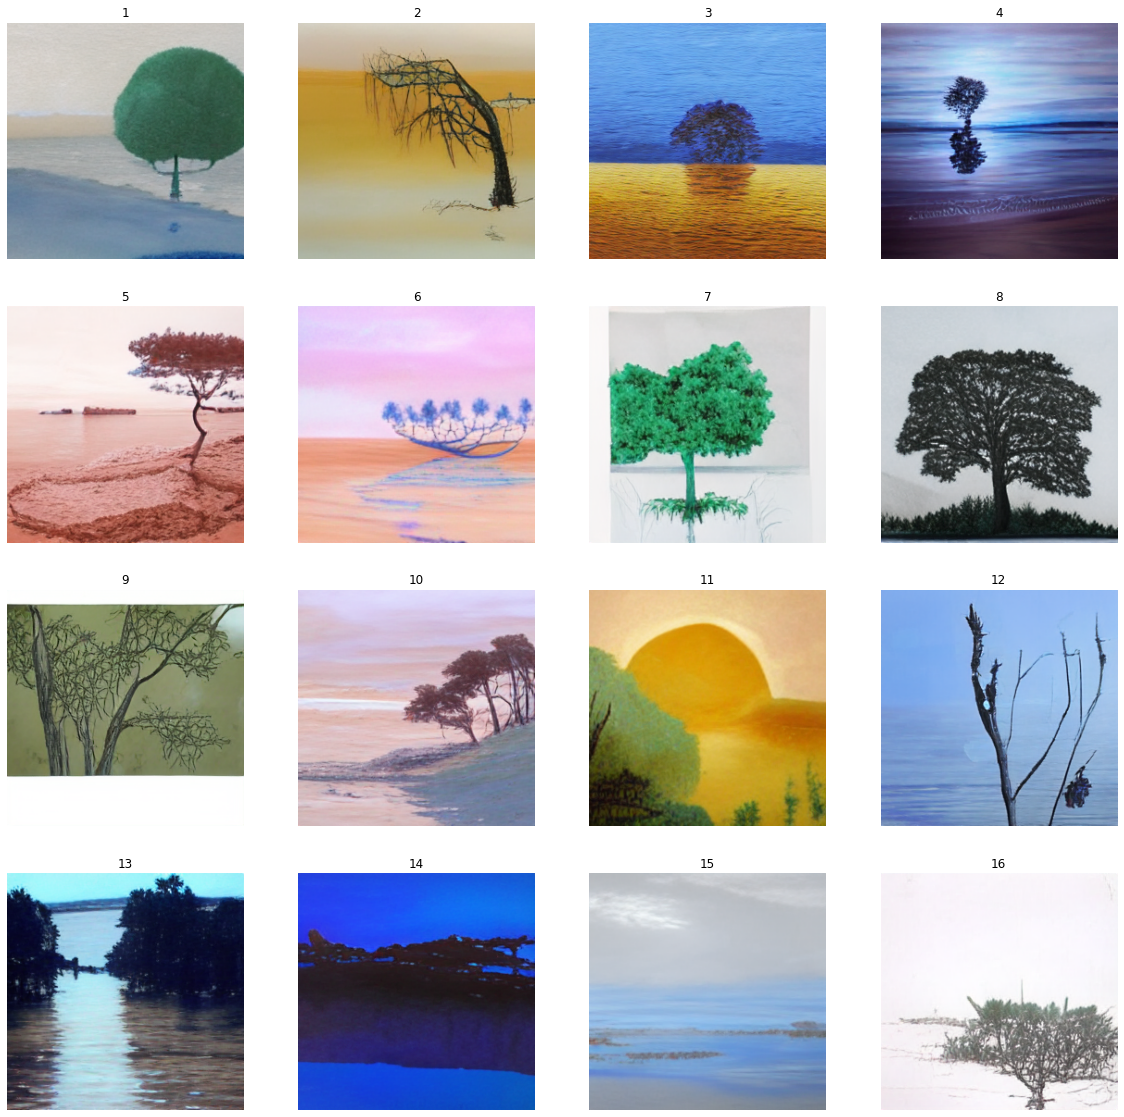

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
  
# create figure
fig = plt.figure(figsize=(20, 20))
  
# setting values to rows and column variables
rows = 4
columns = 4


p = r"/content/minDALL-E/figures/"


for i in range(n):
  img = cv2.imread(p + prompt + '_' + str(i) +'.png')
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'{i+1}')
